In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

(5, 5, 5, 5)


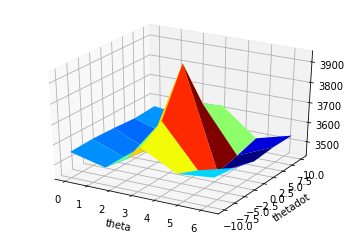

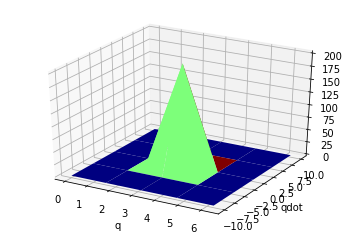

In [2]:
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (
    DiagramBuilder,
    FloatingBaseType,
    RigidBodyTree,
    RigidBodyPlant,
    SignalLogger, 
    Simulator, 
    VectorSystem
)
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from pydrake.examples.acrobot import AcrobotPlant
from underactuated import (
    PlanarRigidBodyVisualizer
)



plant = AcrobotPlant()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()

# State: (theta1, theta2, theta1_dot, theta2_dot) Input: Elbow torque

def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    if x.dot(x) < .05: # seeks get x to (math.pi, 0., 0., 0.)
        return 0.
    return 1.


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + u.dot(u)


if (False):
    cost_function = min_time_cost
    input_limit = 80.
#     options.convergence_tol = 0.001
    options.convergence_tol = 0.003
    state_steps = 7
    input_steps = 9
else:
    cost_function = quadratic_regulator_cost
    input_limit = 800.
    options.convergence_tol = 0.001
    state_steps = 5
    input_steps = 9

qbins = np.linspace(0., 2. * math.pi, state_steps)
qbins2 = np.linspace(0., 2. * math.pi, state_steps)
qdotbins = np.linspace(-10., 10., state_steps)
qdotbins2 = np.linspace(-10., 10., state_steps)
state_grid = [set(qbins), set(qbins2), set(qdotbins), set(qdotbins2)]
options.periodic_boundary_conditions = [
    PeriodicBoundaryCondition(0, 0., 2.*math.pi),
    PeriodicBoundaryCondition(1, 0., 2.*math.pi),
]
input_grid = [set(np.linspace(-input_limit, input_limit, input_steps))]
timestep = 0.01

[Q, Qdot] = np.meshgrid(qbins, qdotbins)
# [Q, Qdot] = np.meshgrid(qbins, qbins2)
# [Q, Qdot] = np.meshgrid(qbins, qbins2, qdotbins, qdotbins2)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")


# def draw(iteration, mesh, cost_to_go, policy):
#     # Drawing is slow, don't draw every frame.
#     if iteration % 10 != 0:
#         return
#     plt.title("iteration " + str(iteration))
#     J = np.reshape(cost_to_go, Q.shape)
#     surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
#                            cmap=cm.jet)

#     Pi = np.reshape(policy, Q.shape)
#     surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     display.display(plt.gcf())
#     display.clear_output(wait=True)


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

# print(type(cost_to_go), cost_to_go.shape)
total_shape = (state_steps,)*4
J = np.reshape(cost_to_go, total_shape)
print(J.shape)
J = J[:,:,0,0]
# J = J[:,0,:,0]
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), total_shape)
Pi = Pi[:,:,0,0]
# Pi = Pi[:,0,:,0]
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)


In [3]:
# # Animate the resulting policy.
# builder = DiagramBuilder()
# tree = RigidBodyTree("/opt/underactuated/src/acrobot/acrobot.urdf",
#                      FloatingBaseType.kFixed)
# plant = RigidBodyPlant(tree)
# plant_system = builder.AddSystem(plant)


# # TODO(russt): add wrap-around logic to barycentric mesh
# # (so the policy has it, too)
# class WrapTheta(VectorSystem):
#     def __init__(self):
#         VectorSystem.__init__(self, 4, 4)

#     def _DoCalcVectorOutput(self, context, input, state, output):
#         output[:] = input
#         twoPI = 2.*math.pi
#         output[0] = output[0] - twoPI * math.floor(output[0] / twoPI)
#         output[1] = output[1] - twoPI * math.floor(output[1] / twoPI)


# wrap = builder.AddSystem(WrapTheta())
# builder.Connect(plant_system.get_output_port(0), wrap.get_input_port(0))
# vi_policy = builder.AddSystem(policy)
# builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
# builder.Connect(vi_policy.get_output_port(0), plant_system.get_input_port(0))

# logger = builder.AddSystem(SignalLogger(4))
# logger._DeclarePeriodicPublish(0.033333, 0.0)
# builder.Connect(plant_system.get_output_port(0), logger.get_input_port(0))

# diagram = builder.Build()
# simulator = Simulator(diagram)
# simulator.set_publish_every_time_step(False)

# state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
# state.SetFromVector([0.5, 0.5, 0.0, 0.0])

from traj.dircol import (
    visualize_policy_system,
)
simulator, tree, logger = visualize_policy_system(policy, "acrobot")

In [4]:
simulator.StepTo(10.)

In [5]:
# Visualize the result as a video.
vis = PlanarRigidBodyVisualizer(tree, xlim=[-4., 4.], ylim=[-4., 4.])
ani = vis.animate(logger, repeat=True)

# plt.show()
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [6]:
x = np.zeros((5, 5, 5, 5))
x = x[:,:,0,0]
x

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [7]:
(4,)*5

(4, 4, 4, 4, 4)